# Denoising AE with MNIST (w/ Pytorch)

Example taken from:

* http://www.opendeep.org/v0.0.5/docs/tutorial-your-first-model

* https://gist.github.com/bigsnarfdude/dde651f6e06f266b48bc3750ac730f80


## Import PyTorch

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Choose cpu/gpu
use_gpu=1
if (use_gpu):
    print('\nEnable gpu')
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda") # Uncomment this to run on GPU
    
else:
    print('\nRun on cpu')
    dtype = torch.FloatTensor
    device = torch.device("cpu")


Enable gpu


## Initialize Hyper-parameters

In [3]:
input_size = 784       # The image size = 28 x 28 = 784
encoding_dim1 = 350    # latence space
encoding_dim2 = 350     # 
num_epochs = 20        # The number of times entire dataset is trained
batch_size = 100       # The size of input data took for one iteration
learning_rate = 0.001  # The speed of convergence

## Download MNIST Dataset

In [4]:
train_dataset = dsets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=False)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

## Load the Dataset

We shuffle the loading process of train_dataset to make the learning process independent of data orderness, but the order of test_loader remains to examine whether we can handle unspecified bias order of inputs.

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## Add noise to data

In [6]:
def add_noise(data,scale):
    noise = torch.randn(data.shape) * scale
    noisy_data = data + noise
    return noisy_data

# Alternative possibilities
def salt_and_pepper(data,frac):
    """set frac of values to 0 or 1"""
    temp = data.clone()
    temp = temp.flatten()    # flatten the tensor for more simplicity
    dim  = temp.shape[0] # tensor lenght
    #dim  = temp.numpy().size # tensor lenght
    num  = round(dim*frac)   # number of values to change
    #ind0 = np.random.choice(dim, size=num) # index of 0
    ind1 = np.random.choice(dim, size=num) # index of 1
    #temp[ind0]=0
    temp[ind1]=1
    temp = temp.reshape(data.shape)
    return temp

def data_with_zeros(data):
    # Set some of the input variables to zero
    # zeros = torch.round(torch.rand(data.shape)*1.49).type(dtype) # tensor with only 0 or 1 values (about 33% are zeros)
    zeros = torch.round(torch.rand(data.shape)) # tensor with only 0 or 1 values (about 50% are zeros)
    return data*zeros

## Let's take a look at some examples. 
We'll use the test_loader for this.

batch data: torch.Size([100, 1, 28, 28])


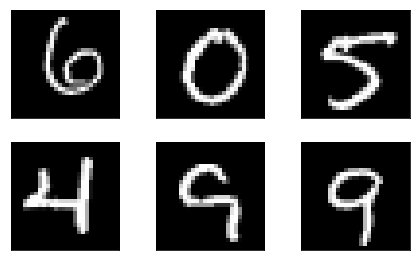

In [9]:
#examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# Let's see what one test data batch consists of
# --> we have [batch_size] examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one). 
print("batch data:", example_data.shape)

# Plot some examples with matplotlib
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  #plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
    
plt.show()

## Look at corrupted data

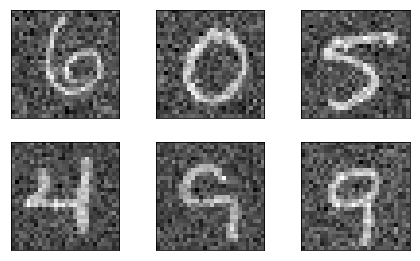

In [10]:
scale = 0.2
corrupted_data = add_noise(example_data,scale)

#fcor  = 0.20 # fraction of corrupted pixels (set to 0 or 1)
#corrupted_data = salt_and_pepper(example_data,fcor)

# Plot some examples with matplotlib
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(corrupted_data[i][0], cmap='gray', interpolation='none')
  #plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
    
plt.show()

## Autoencoder model

In [9]:
net = nn.Sequential(
        nn.Linear(input_size, encoding_dim1),
        nn.ReLU(True),
        nn.Linear(encoding_dim1, encoding_dim2),
        nn.ReLU(True),
        nn.Linear(encoding_dim2, encoding_dim1),
        nn.ReLU(True),
        nn.Linear(encoding_dim1, input_size),
        nn.Sigmoid()
)

## Enable GPU 

In [10]:
net.cuda()    # You can comment out this line to disable GPU

Sequential(
  (0): Linear(in_features=784, out_features=350, bias=True)
  (1): ReLU(inplace)
  (2): Linear(in_features=350, out_features=350, bias=True)
  (3): ReLU(inplace)
  (4): Linear(in_features=350, out_features=350, bias=True)
  (5): ReLU(inplace)
  (6): Linear(in_features=350, out_features=784, bias=True)
  (7): Sigmoid()
)

## Choose the Loss Function and Optimizer

In [11]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# alternative Stochastic Gradient Descent (give worse results and needs 20xlr and 20 epochs)
#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [12]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(num_epochs + 1)]

## Load existing model (optional)

In [14]:
net.load_state_dict(torch.load('models/dae_mnist_model_%d_%d.pkl' % (encoding_dim1,encoding_dim2)))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train the DAE Model

Note: torch.nn only supports mini-batches. The entire torch.nn package only supports inputs that are a mini-batch of samples, and not a single sample. If you have a single sample, just use input.unsqueeze(0) to add a fake batch dimension.

## Evaluating the Model's Performance

## Test denoising AE

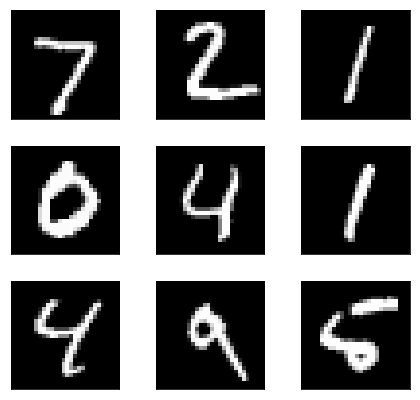

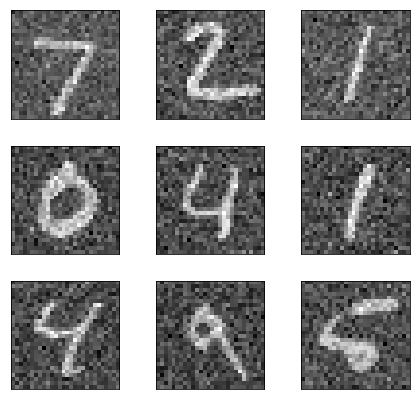

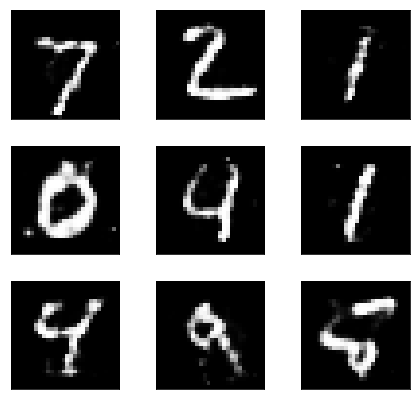

In [16]:
examples = enumerate(test_loader)
batch_idx, (images, labels) = next(examples)

# Plot some examples with matplotlib
figsize=(6,6)

# original image
#images = Variable(images.view(-1, 28*28))
plt.figure(figsize=figsize)
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray', interpolation='none')
  #plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
#plt.show()
plt.savefig("images/dae/digit_original_%d.png" %(batch_idx))

# corrupted image
#corrupted_images = data_with_zeros(images)
#corrupted_images = salt_and_pepper(images,fcor)
corrupted_images = add_noise(images,scale)
plt.figure(figsize=figsize)
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(corrupted_images[i][0], cmap='gray', interpolation='none')
  #plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
#plt.show()
plt.savefig("images/dae/digit_noisy_%d.png" %(batch_idx))
corrupted_images = Variable(corrupted_images.view(-1, 28*28))

# reco image
reco_images = net(corrupted_images.type(dtype))
reco_images = Variable(reco_images.view(-1,1,28,28))
plt.figure(figsize=figsize)

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(reco_images.cpu()[i][0], cmap='gray', interpolation='none')
  #plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
#plt.show()
plt.savefig("images/dae/digit_reco_%d.png" %(batch_idx))